<a href="https://colab.research.google.com/github/jwesierski/Atom-Projex/blob/master/MindsAI_EEG_Data_Formatting_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jack-Michael's Dataset

Need to place signal filtering functions into a script

## Magic Command: Auto-Reloading Packages for Easy Iteration

In [2]:
#%load_ext autoreload
#%autoreload 2

#accessing database directly from google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#storage location in colab. Only needs to be done once and everytime there is an update to data.
#So if this gives issues it can be commented out after import and mount.

#Keep the below format for importing new files. Assign to eeg_csv for reuse.
# #CS = Calibration Session
# #PS = Prediction Session (not formatted for training atm)
# DEAP_data_drive_file = r"/content/drive/MyDrive/MindsApplied/Data Analysis/DEAP Dataset/data_preprocessed_python"

#Raw=Raw EEG Data
#Log = qualitative trial details: Labeling, timestamp, electrodes, sampling rate
#Trial = quantitative trial details: trial numbers, and start and end time
S10_Calibration_Session_003_Raw= r"/content/drive/MyDrive/MindsApplied/Data Analysis/User Recordings/Emotional Recognition/DragonEEG/S10/CS001/EEG.csv"
S10_Calibration_Session_003_Log = r"/content/drive/MyDrive/MindsApplied/Data Analysis/User Recordings/Emotional Recognition/DragonEEG/S10/CS001/log_updated (S10).csv"
S10_Calibration_Session_003_Trial = r"/content/drive/MyDrive/MindsApplied/Data Analysis/User Recordings/Emotional Recognition/DragonEEG/S10/CS001/trial_results.csv"

eeg_raw_csv = S10_Calibration_Session_003_Raw
eeg_trial_csv = S10_Calibration_Session_003_Trial
eeg_log_csv = S10_Calibration_Session_003_Log

dragon_eeg_sampling_rate = 500  # Hz

trial_results = pd.read_csv(eeg_trial_csv)
trial_results = trial_results.sort_values('start_time')

Mounted at /content/drive


## Loading and Organizing Data

[link text](https://)### Data Types

| Channel Type           | Scale/Units                      | Dataframe Column Name          | Inferred Sampling Rate |
|------------------------|-----------------------------------|--------------------------------|------------------------|
| EEG Channels            | Microvolts (µV)                  | EEG_Fz_µV, EEG_C3_µV, ..., EEG_F8_µV | 500 Hz             |
| ECG Channels            | *Microvolts (µV)* (?)            | ECG_1 to ECG_16                | Not applicable           |
| EMG Channels            | *Microvolts (µV)* (?)            | EMG_1 to EMG_16                | Not applicable           |
| EOG Channels            | *Microvolts (µV)* (?)            | EOG_1 to EOG_16                | Not applicable           |
| Accel Channels          | *g (Gravity)* (?)                | ACCEL_1, ACCEL_2, ACCEL_3      | 25 Hz               |
| Gyro Channels           | *Degrees per second (°/s)* (?)   | GYRO_1, GYRO_2, GYRO_3         | 50 Hz               |
| PPG Channels            | *Arbitrary units (A.U.)* (?)     | PPG_1, PPG_2                   | 50 Hz               |
| EDA Channels            | *Microsiemens (µS)* (?)          | EDA                            | 50 Hz               |
| Resistance Channels     | *Ohms (Ω)* (?)                  | Resistance_1, Resistance_2     | Not applicable           |
| Temperature Channels    | *Degrees Celsius (°C)* (?)       | Temperature                    | 45 Hz               |
| Battery Channel         | *Volts (V)* (?)                 | Battery                        | Not provided           |
| Package Number Channel  | Integer                          | package_num                    | Not applicable         |
| Marker Channel          | Event Marker                     | marker                         | Not applicable         |
| Timestamp Channel       | UNIX time (seconds)              | timestamp                      | Not applicable         |


### Code

In [3]:
import pandas as pd

# Load the dataframe with no header
#dragon_eeg uses spaces (\\s+) not tabs. change seconds paramter to sep='\t' for spaces
eeg_data_frame = pd.read_csv(eeg_raw_csv, sep='\\s+', header=None)
print(eeg_data_frame.shape)

def get_eeg_names_from_file(eeg_log_csv: str) -> list:
    """
    Extracts EEG channel names from the log file.

    Parameters:
    - eeg_log_csv (str): Path to the log

    Returns:
    - eeg_names (list): List of EEG channel names.
    """
    # Read the CSV file
    log_df = pd.read_csv(eeg_log_csv)

    # Search for the row where the "message" column contains the electrode names
    eeg_name_row = log_df[log_df['message'].str.contains("EEG Electrode Names in order:", na=False)]

    # If the row exists, extract the names
    if not eeg_name_row.empty:
        # Extract the message text and get the part after the known prefix
        eeg_names_string = eeg_name_row.iloc[0]['message'].replace("EEG Electrode Names in order:", "").strip()

        # Split the names by spaces and return the list
        eeg_names = eeg_names_string.split()
        return eeg_names
    else:
        raise ValueError("EEG Electrode Names not found in the file.")

def process_eeg_dataframe_with_labels(df: pd.DataFrame, eeg_names: list):
    """
    Processes the EEG DataFrame by assigning the appropriate labels to each column.

    Parameters:
    - eeg_data_frame (pd.DataFrame): The input EEG DataFrame with no header.
    - eeg_names (list): List of EEG channel names from the log file.

    Returns:
    - eeg_data_frame (pd.DataFrame): The DataFrame with assigned column labels.
    """
    # Define the channel labels according to the rubric
    markiv_channel_info = {
        "package_num_channel": 0,
        "eeg_channels": list(range(1, 17)),
        "emg_channels": list(range(1, 17)),
        "eog_channels": list(range(1, 17)),
        "ecg_channels": list(range(1, 17)),
        "accel_channels": [17, 18, 19],
        "gyro_channels": [20, 21, 22],
        "eda_channels": [23],
        "ppg_channels": [24, 25],
        "temperature_channels": [26],
        "resistance_channels": [27, 28],
        "battery_channel": 29,
        "timestamp_channel": 30,
        "marker_channel": 31
    }
# the first eeg column O1 seems to have a consistent range which may point to skewed data.
    dragon_eeg_channel_info = {
        "package_num_channel": 0,
        "eeg_channels": list(range(1, 25))
    }

    channel_info = dragon_eeg_channel_info

    # Create a column mapping list
    column_labels = []

    if channel_info == markiv_channel_info:
      for i in range(eeg_data_frame.shape[1]):
          if i == channel_info["package_num_channel"]:
              column_labels.append("package_num")
          elif i in channel_info["eeg_channels"]:
              eeg_index = channel_info["eeg_channels"].index(i)
              column_labels.append(f"EEG_{eeg_names[eeg_index]}_mV")  # Use names dynamically from file
          elif i in channel_info["accel_channels"]:
              accel_index = channel_info["accel_channels"].index(i) + 1
              column_labels.append(f"ACCEL_{accel_index}")
          elif i in channel_info["gyro_channels"]:
              gyro_index = channel_info["gyro_channels"].index(i) + 1
              column_labels.append(f"GYRO_{gyro_index}")
          elif i == channel_info["battery_channel"]:
              column_labels.append("Battery")
          elif i == channel_info["timestamp_channel"]:
              column_labels.append("timestamp")
          elif i == channel_info["marker_channel"]:
              column_labels.append("marker")
          elif i in channel_info["eda_channels"]:
              column_labels.append("EDA")
          elif i in channel_info["ppg_channels"]:
              ppg_index = channel_info["ppg_channels"].index(i) + 1
              column_labels.append(f"PPG_{ppg_index}")
          elif i in channel_info["resistance_channels"]:
              resistance_index = channel_info["resistance_channels"].index(i) + 1
              column_labels.append(f"Resistance_{resistance_index}")
          elif i in channel_info["temperature_channels"]:
              column_labels.append("Temperature")
          else:
              column_labels.append(f"Unknown_Channel_{i}")

      # Assign these labels to the dataframe's columns
      eeg_data_frame.columns = column_labels

      return eeg_data_frame

    elif channel_info == dragon_eeg_channel_info:
      for i in range(eeg_data_frame.shape[1]):
          if i == channel_info["package_num_channel"]:
              column_labels.append("package_num")
          elif i in channel_info["eeg_channels"]:
              eeg_index = channel_info["eeg_channels"].index(i)
              column_labels.append(f"EEG_{eeg_names[eeg_index]}_mV")  # Use names dynamically from file
          else:
              column_labels.append(f"Unknown_Channel_{i}")

      # Assign these labels to the dataframe's columns
      eeg_data_frame.columns = column_labels

      return eeg_data_frame

# Example usage:
# Get EEG names from the log file
eeg_names = get_eeg_names_from_file(eeg_log_csv)

# Process the DataFrame with the extracted EEG names
df = process_eeg_dataframe_with_labels(eeg_data_frame, eeg_names)

# Display the first few rows of the processed DataFrame
eeg_data_frame.head()

(523890, 25)


,package_num,EEG_O1_mV,EEG_P3_mV,EEG_C3_mV,EEG_F3_mV,EEG_Fp1_mV,EEG_T5_mV,EEG_T3_mV,EEG_F7_mV,EEG_O2_mV,...,EEG_T4_mV,EEG_F8_mV,EEG_D1_mV,EEG_D2_mV,EEG_D3_mV,EEG_OZ_mV,EEG_PZ_mV,EEG_CZ_mV,EEG_FZ_mV,EEG_FpZ_mV
0,0,0.618229,-0.095468,0.553979,-0.055930,0.569896,-0.050334,0.010842,0.004662,0.399728,...,0.120542,0.065101,0.308451,0.422070,0.280479,0.464397,0.697086,0.568811,-0.035305,-0.176038
1,1,0.588627,-0.108004,0.203230,-0.063202,0.500382,-0.075235,-0.026224,-0.001590,0.195105,...,0.088590,0.056728,-0.070263,0.172643,-0.022695,0.220262,0.677879,0.492303,-0.051391,-0.176853
2,2,0.077657,-0.121647,-0.422052,-0.072544,0.030439,-0.097179,-0.063158,-0.009136,-0.138426,...,0.057527,0.047733,-0.750000,-0.619970,-0.750000,-0.467538,0.059060,-0.423674,-0.068430,-0.178063
3,3,0.160644,-0.116284,-0.283158,-0.070126,0.127683,-0.084057,-0.045800,-0.006009,-0.005528,...,0.071240,0.051824,-0.750000,-0.750000,-0.750000,-0.240812,0.050494,-0.514627,-0.062161,-0.179059
4,4,0.427196,-0.112544,-0.067755,-0.068319,0.398462,-0.074812,-0.032062,-0.003216,0.143472,...,0.081052,0.055240,-0.750000,-0.725403,-0.750000,0.217759,0.306970,-0.378992,-0.057859,-0.180523


## Tabular Reports

### Summary Report

In [4]:
import pandas as pd

def generate_summary_report(eeg_data_frame: pd.DataFrame):
    summary_data = []

    for column in eeg_data_frame.columns:
        # Collecting statistics for each column
        data_type = eeg_data_frame[column].dtype
        non_null_count = eeg_data_frame[column].count()
        mean = eeg_data_frame[column].mean() if pd.api.types.is_numeric_dtype(eeg_data_frame[column]) else None
        median = eeg_data_frame[column].median() if pd.api.types.is_numeric_dtype(eeg_data_frame[column]) else None
        std = eeg_data_frame[column].std() if pd.api.types.is_numeric_dtype(eeg_data_frame[column]) else None
        min_value = eeg_data_frame[column].min() if pd.api.types.is_numeric_dtype(eeg_data_frame[column]) else None
        max_value = eeg_data_frame[column].max() if pd.api.types.is_numeric_dtype(eeg_data_frame[column]) else None

        # Append summary information for each column
        summary_data.append({
            'Column': column,
            'Data Type': data_type,
            'Non-Null Count': non_null_count,
            'Mean': mean,
            'Median': median,
            'Std Dev': std,
            'Min': min_value,
            'Max': max_value
        })

    # Create a summary dataframe
    summary_df = pd.DataFrame(summary_data)

    # Return the summary
    return summary_df

# Example usage:
summary_df = generate_summary_report(eeg_data_frame)
display(summary_df)  # Using display to show the dataframe in JupyterLab

,Column,Data Type,Non-Null Count,Mean,Median,Std Dev,Min,Max
0,package_num,int64,523890,261944.500000,261944.500000,151234.160600,0.000000,523889.000000
1,EEG_O1_mV,float64,523890,0.611316,0.629303,0.073811,-0.015440,0.750000
2,EEG_P3_mV,float64,523890,-0.075678,-0.071119,0.007668,-0.121647,-0.067635
3,EEG_C3_mV,float64,523890,-0.062959,-0.058828,0.017810,-0.422052,0.553979
4,EEG_F3_mV,float64,523890,-0.054857,-0.051285,0.010247,-0.077703,-0.042780
5,EEG_Fp1_mV,float64,523890,0.270945,0.129291,0.249013,-0.094353,0.720458
6,EEG_T5_mV,float64,523890,-0.076384,-0.073103,0.012493,-0.103459,-0.050334
7,EEG_T3_mV,float64,523890,0.013199,0.019464,0.014948,-0.063158,0.032237
8,EEG_F7_mV,float64,523890,0.005735,0.003253,0.007182,-0.009136,0.020213
9,EEG_O2_mV,float64,523890,0.178879,0.149812,0.099671,-0.138426,0.667623


In [13]:
import numpy as np
import pandas as pd

print("Columns:", trial_results.columns.tolist())

def label_markiv_eeg_data(eeg_data_frame: pd.DataFrame, timestamps: pd.Series, trial_results: pd.DataFrame) -> pd.DataFrame:
    """
    Labels the EEG data based on trial intervals. Assigns labels from trial_results['word'] to corresponding
    EEG data based on trial start/end times, and assigns NA for rows outside trial intervals.

    Parameters:
    - eeg_data_frame (pd.DataFrame): DataFrame containing EEG data.
    - timestamps (pd.Series): Series of timestamps corresponding to the EEG data.
    - trial_results (pd.DataFrame): DataFrame containing trial information, including 'start_time', 'end_time', and 'word'.

    Returns:
    - labeled_eeg_data_frame (pd.DataFrame): A new DataFrame with an additional 'label' column containing word labels for EEG data.
    """
    # Initialize an array to hold labels, defaulting to NA
    labels = pd.Series(np.nan, index=eeg_data_frame.index)

    # Iterate over each trial interval and assign labels
    for i, row in trial_results.iterrows():
        start_time = row['start_time']
        end_time = row['end_time']
        word_label = row['word']

        # Find the EEG rows that fall within the current trial's time range
        in_trial = (timestamps >= start_time) & (timestamps <= end_time)

        # Assign the label for these rows
        labels[in_trial] = word_label

    # Add the labels as a new column in the eeg_data_frame
    labeled_eeg_data_frame = eeg_data_frame.copy()
    labeled_eeg_data_frame['label'] = labels


def label_dragon_eeg_data(eeg_data_frame: pd.DataFrame, trial_results: pd.DataFrame, sampling_rate: int = 500) -> pd.DataFrame:
    """
    Labels EEG data based on trial start/end times, inferring timestamps from `package_num` using sampling rate.
    Adds labels for word, valence, arousal, dominance, and liking.

    Parameters:
    - eeg_data_frame (pd.DataFrame): EEG data with 'package_num' column.
    - trial_results (pd.DataFrame): Trial metadata with 'start_time', 'end_time', and emotion labels.
    - sampling_rate (int): EEG sampling rate in Hz (default: 500).

    Returns:
    - labeled_eeg_data_frame (pd.DataFrame): EEG dataframe with estimated timestamps and emotion labels.
    """
    # Infer timestamps using sample rate
    # Updated anchor logic
    first_trial_unix_time = trial_results['start_time'].min()
    first_trial_row_index = 169.7935 * 500  # = 84896 anchor start time grabbed by comparing log_updated line 14 (169.7935)*sampling_rate with trial_results start_time(1742353236380720)
    anchor_package_num = first_trial_row_index
    us_per_sample = 1_000_000 / 500

    # New anchor based on row offset
    anchor_unix_us = first_trial_unix_time - (anchor_package_num * us_per_sample)

    # Initialize label columns
    labeled_eeg_data_frame = eeg_data_frame.copy()
    label_columns = ['word', 'valence', 'arousal', 'dominance', 'liking']

    for col in label_columns:
      labeled_eeg_data_frame[col] = pd.Series(dtype="object")  # allows strings and numbers safely

    # Compute estimated_unix_us based on adjusted anchor
    labeled_eeg_data_frame['estimated_unix_us'] = anchor_unix_us + (labeled_eeg_data_frame['package_num'] * us_per_sample).astype(int)

    for col in label_columns:
        labeled_eeg_data_frame[col] = np.nan

    # Assign labels from trial windows
    for _, row in trial_results.iterrows():
        in_trial = (labeled_eeg_data_frame['estimated_unix_us'] >= row['start_time']) & \
                   (labeled_eeg_data_frame['estimated_unix_us'] <= row['end_time'])
        for col in label_columns:
            labeled_eeg_data_frame.loc[in_trial, col] = row[col]

    return labeled_eeg_data_frame

def trim_labeled_eeg_data_by_trial(
    labeled_eeg_data_frame: pd.DataFrame,
    trial_results: pd.DataFrame,
    sampling_rate: int = 500
) -> dict:
    """
    Trims EEG data for each trial:
    - For trials 1–5: keep last 60 seconds.
    - For trial 6: keep 60 seconds starting after the first 30 seconds, because this trial went forever due to computer dying. If data is skewed, reduce to 15 seconds or less

    Returns a dictionary of trial index → trimmed EEG DataFrame.
    """
    trimmed_segments = {}

    for i, row in trial_results.iterrows():
        trial_start = row['start_time']
        trial_end = row['end_time']
        duration_us = trial_end - trial_start
        one_min_us = 60 * 1_000_000
        thirty_sec_us = 30 * 1_000_000

        if i < 5:
            # Keep last 60 seconds
            start_trim = max(trial_end - one_min_us, trial_start)
            end_trim = trial_end
        else:
            # Trial 6: skip first 30s, then keep next 60s
            start_trim = trial_start + thirty_sec_us
            end_trim = start_trim + one_min_us
            end_trim = min(end_trim, trial_end)  # ensure we don't exceed trial bounds

        trimmed = labeled_eeg_data_frame[
            (labeled_eeg_data_frame['estimated_unix_us'] >= start_trim) &
            (labeled_eeg_data_frame['estimated_unix_us'] <= end_trim)
        ]

        trimmed_segments[i] = trimmed
    return trimmed_segments

# Label EEG data based on trials
labeled_eeg_data_frame = label_dragon_eeg_data(eeg_data_frame, trial_results)

#trimmed to only necessary 1 minute for each trial
eeg_in_trial_trimmed = trim_labeled_eeg_data_by_trial(labeled_eeg_data_frame, trial_results)


print("\n--- Trial-to-EEG Alignment  and Reduction Summary ---")

# First: call trimming method
eeg_in_trial_trimmed = trim_labeled_eeg_data_by_trial(labeled_eeg_data_frame, trial_results)

for i, row in trial_results.iterrows():
    trial_word = row['valence']
    start_unix = row['start_time']
    end_unix = row['end_time']

    eeg_in_trial = labeled_eeg_data_frame[
        (labeled_eeg_data_frame['estimated_unix_us'] >= start_unix) &
        (labeled_eeg_data_frame['estimated_unix_us'] <= end_unix)
    ]

    trimmed = eeg_in_trial_trimmed.get(i)

    if not eeg_in_trial.empty:
        first_row = eeg_in_trial.iloc[0]
        last_row = eeg_in_trial.iloc[-1]

        start_pkg = first_row['package_num']
        end_pkg = last_row['package_num']
        est_start_unix = first_row['estimated_unix_us']
        est_end_unix = last_row['estimated_unix_us']

        print(f"\nTrial {i+1} - Valence: {trial_word}")
        print(f"• Trial Start Time (Unix): {start_unix}")
        print(f"• Trial End Time   (Unix): {end_unix}")
        print(f"• Total EEG Rows Before Trim: {len(eeg_in_trial)}")
        print(f"• First EEG Row → package_num: {start_pkg}, estimated_unix_us: {est_start_unix}")
        print(f"• Last EEG Row  → package_num: {end_pkg}, estimated_unix_us: {est_end_unix}")

        if trimmed is not None and not trimmed.empty:
            print(f"• Trimmed EEG Rows: {len(trimmed)}")
            print(f"• Trimmed Start → package_num: {trimmed.iloc[0]['package_num']}, estimated_unix_us: {trimmed.iloc[0]['estimated_unix_us']}")
            print(f"• Trimmed End   → package_num: {trimmed.iloc[-1]['package_num']}, estimated_unix_us: {trimmed.iloc[-1]['estimated_unix_us']}")
        else:
            print("Trimmed segment is empty or missing.")

        us_per_sample = 1_000_000 / 500
        print(f"• Estimated Start = anchor_unix + package_num * us_per_sample = {start_pkg} * {us_per_sample:.1f} + anchor → {est_start_unix}")
    else:
        print(f"\n Trial {i+1} - Valence: {trial_word} has NO matching EEG rows")



# Display the labeled EEG data
labeled_eeg_data_frame.head()

Columns: ['experiment', 'ppid', 'session_num', 'trial_num', 'block_num', 'trial_num_in_block', 'start_time', 'end_time', 'word', 'valence', 'arousal', 'dominance', 'liking']

--- Trial-to-EEG Alignment  and Reduction Summary ---

Trial 1 - Valence: 5
• Trial Start Time (Unix): 1742353236380720
• Trial End Time   (Unix): 1742353301498070
• Total EEG Rows Before Trim: 32559
• First EEG Row → package_num: 84897, estimated_unix_us: 1742353236381220.0
• Last EEG Row  → package_num: 117455, estimated_unix_us: 1742353301497220.0
• Trimmed EEG Rows: 30000
• Trimmed Start → package_num: 87456, estimated_unix_us: 1742353241499220.0
• Trimmed End   → package_num: 117455, estimated_unix_us: 1742353301497220.0
• Estimated Start = anchor_unix + package_num * us_per_sample = 84897 * 2000.0 + anchor → 1742353236381220.0

Trial 2 - Valence: 2
• Trial Start Time (Unix): 1742353379549590
• Trial End Time   (Unix): 1742353472089050
• Total EEG Rows Before Trim: 46269
• First EEG Row → package_num: 156482,

<ipython-input-13-b2fb0231a460>:80: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nothing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labeled_eeg_data_frame.loc[in_trial, col] = row[col]


,package_num,EEG_O1_mV,EEG_P3_mV,EEG_C3_mV,EEG_F3_mV,EEG_Fp1_mV,EEG_T5_mV,EEG_T3_mV,EEG_F7_mV,EEG_O2_mV,...,EEG_PZ_mV,EEG_CZ_mV,EEG_FZ_mV,EEG_FpZ_mV,word,valence,arousal,dominance,liking,estimated_unix_us
0,0,0.618229,-0.095468,0.553979,-0.055930,0.569896,-0.050334,0.010842,0.004662,0.399728,...,0.697086,0.568811,-0.035305,-0.176038,NaN,NaN,NaN,NaN,NaN,1.742353e+15
1,1,0.588627,-0.108004,0.203230,-0.063202,0.500382,-0.075235,-0.026224,-0.001590,0.195105,...,0.677879,0.492303,-0.051391,-0.176853,NaN,NaN,NaN,NaN,NaN,1.742353e+15
2,2,0.077657,-0.121647,-0.422052,-0.072544,0.030439,-0.097179,-0.063158,-0.009136,-0.138426,...,0.059060,-0.423674,-0.068430,-0.178063,NaN,NaN,NaN,NaN,NaN,1.742353e+15
3,3,0.160644,-0.116284,-0.283158,-0.070126,0.127683,-0.084057,-0.045800,-0.006009,-0.005528,...,0.050494,-0.514627,-0.062161,-0.179059,NaN,NaN,NaN,NaN,NaN,1.742353e+15
4,4,0.427196,-0.112544,-0.067755,-0.068319,0.398462,-0.074812,-0.032062,-0.003216,0.143472,...,0.306970,-0.378992,-0.057859,-0.180523,NaN,NaN,NaN,NaN,NaN,1.742353e+15


### Timestamp Report

#### ACC + GYRO + Temperature Data + EEG

In [6]:
import pandas as pd

# Function to remove consecutive repeaeeg_data_framews
def remove_repeated_samples(eeg_data_frame: pd.DataFrame, data_columns: list) -> pd.DataFrame:
    """
    Removes consecutive repeated rows where the data is the same across all specified columns.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data and timestamps.
    - data_columns (list): List of column names to check for repeated values.

    Returns:
    - df_cleaned (pd.DataFrame): A new DataFrame with consecutive repeated rows removed.
    """
    # Subset the DataFrame to include only specified columns
    data = eeg_data_frame[data_columns]

    # Detect where rows are different from the previous row (i.e., changes occur)
    changes = data.diff().abs().sum(axis=1) > 0

    # Keep the first row (because diff will make the first row NaN)eeg_data_framell rows with changes
    eeg_data_frame_cleaned = eeg_data_frame.loc[changes.fillna(True)]

    return eeg_data_frame_cleaned

'''
def infer_sampling_rate_for_data(df: pd.DataFrame, data_columns: list, row_range: slice) -> float:
    """
    Cleans the data by removing repeated rows and infers the sampling rate from timestamps.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data and timestamps.
    - data_columns (list): List of column names to inspect for changes and remove repeats.
    - row_range (slice): The row range to consider for calculating the sampling rate.

    Returns:
    - sampling_rate (float): The inferred sampling rate after cleaning the data.
    """
    # Remove repeated samples
    df_cleaned = remove_repeated_samples(df, data_columns)

    # Now infer the sampling rate from the cleaned data using the existing function
    sampling_rate = infer_sampling_rate_from_timestamps(df_cleaned, row_range)

    return sampling_rate

# Function to infer sampling rate using timestamps after removing repeated rows
def infer_sampling_rate_for_daeeg_data_frame pd.DataFrame, data_columns: list, row_range: slice) -> float:
    """
    Cleans the data by removing repeated rows and infers the sampling rate from timestamps.

    Parameters:
    - eeg_data_frame (pd.DataFrame): The input DataFrame containing the data and timestamps.
    - data_columns (list): List of column names to inspect for changes and remove repeats.
    - row_range (slice)eeg_data_framerow range to consider for calculating the sampling rate.

    Returns:
    - sampling_rate (float): The inferred sampling rate after cleaning the data.
    """
    # Remove repeated samples
    eeg_data_frame_cleaned = remove_repeated_samples(df, data_columns)

    # Now infer the sampling rate from the cleaned data using the existing function
    sampling_rate = infer_sampling_rate_from_timestamps(df_cleaned, row_range)

    return sampling_rate


# ACC Data
# We do not expect every row to correspond to a sampling act intended to retrieve ACC data.
acc_columns = ['ACCEL_1', 'ACCEL_2', 'ACCEL_3']
acc_row_range = slice(0, 100)
acc_sampling_rate = infer_sampling_rate_for_data(df, acc_columns, acc_row_range)
print(f"Inferred sampling rate for ACC data: {acc_sampling_rate:.2f} Hz")


# Gyroscope Data
# We do not expect every row to correspond to a sampling act intended to retrieve Gyro data.
gyro_columns = ['GYRO_1', 'GYRO_2', 'GYRO_3']
gyro_row_range = slice(0, 100)
gyro_sampling_rate = infer_sampling_rate_for_data(df, gyro_columns, gyro_row_range)
print(f"Inferred sampling rate for Gyroscope data: {gyro_sampling_rate:.2f} Hz")


# Temperature Data
# We do not expect every row to correspond to a sampling act intended to retrieve Temperature data.
temperature_columns = ['Temperature']
temperature_row_range = slice(0, 100)
temperature_sampling_rate = infer_sampling_rate_for_data(df, temperature_columns, temperature_row_range)
print(f"Inferred sampling rate for Temperature data: {temperature_sampling_rate:.2f} Hz")

# EDA Data (Electrodermal Activity)
eda_columns = ['EDA']  # Assuming EDA has one column named 'EDA'
eda_row_range = slice(0, 100)
eda_sampling_rate = infer_sampling_rate_for_data(df, eda_columns, eda_row_range)
print(f"Inferred sampling rate for EDA data: {eda_sampling_rate:.2f} Hz")


# PPG Data (Photoplethysmogram)
ppg_columns = ['PPG_1', 'PPG_2']  # Assuming PPG has two columns named 'PPG_1' and 'PPG_2'
ppg_row_range = slice(0, 100)
ppg_sampling_rate = infer_sampling_rate_for_data(df, ppg_columns, ppg_row_range)
print(f"Inferred sampling rate for PPG data: {ppg_sampling_rate:.2f} Hz")


# EEG Data
# We do not expect every row to correspond to a sampling act intended to retrieve EEG data.
markiv_eeg_columns = ['EEG_P7_mV', 'EEG_O1_mV', 'EEG_P3_mV', 'EEG_C3_mV', 'EEG_C4_mV', 'EEG_P4_mV', 'EEG_P8_mV',
               'EEG_O2_mV', 'EEG_T7_mV', 'EEG_F7_mV', 'EEG_FP1_mV', 'EEG_F3_mV', 'EEG_F4_mV', 'EEG_FP2_mV',
               'EEG_F8_mV', 'EEG_T8_mV']
'''
markiv_eeg_columns = ['EEG_O1_mV', 'EEG_P3_mV', 'EEG_C3_mV', 'EEG_F3_mV', 'EEG_Fp1_mV', 'EEG_T5_mV', 'EEG_T3_mV', 'EEG_F7_mV',
               'EEG_O2_mV', 'EEG_P4_mV', 'EEG_C4_mV', 'EEG_F4_mV', 'EEG_Fp2_mV', 'EEG_T6_mV', 'EEG_T4_mV',
               'EEG_F8_mV', 'EEG_D1_mV', 'EEG_D2_mV', 'EEG_D3_mV', 'EEG_OZ_mV', 'EEG_PZ_mV' 'EEG_CZ_mV', 'EEG_FZ_mV',
               'EEG_FpZ_mV']

eeg_row_range = slice(0, 100)
eeg_sampling_rate = dragon_eeg_sampling_rate
print(f"Inferred sampling rate for EEG data: {eeg_sampling_rate:.2f} Hz")

Inferred sampling rate for EEG data: 500.00 Hz


#### Evaluating Trial Timestamps

<ipython-input-5-cb3a69bd9bf2>:78: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'nothing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  labeled_eeg_data_frame.loc[in_trial, col] = row[col]


Initial Start Time: 1742353236380720 is within the range 1742353066587220.0 and 1742354114365220.0: True
Final End Time: 1742364447868410 is within the range 1742353066587220.0 and 1742354114365220.0: False


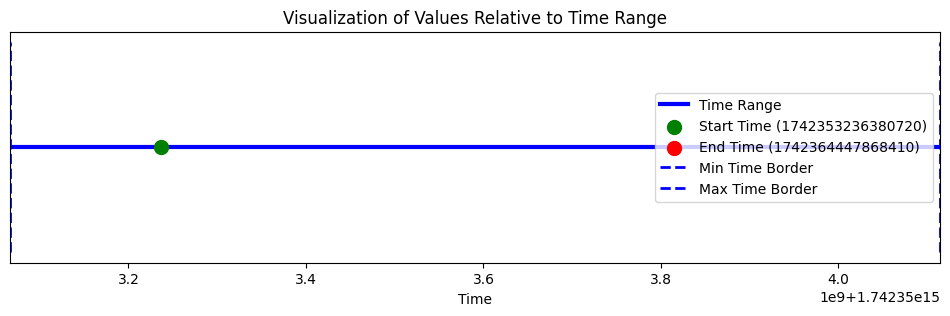

In [7]:
import matplotlib.pyplot as plt

# Convert time columns to numeric in case they're not already
trial_results['start_time'] = pd.to_numeric(trial_results['start_time'], errors='coerce')
trial_results['end_time'] = pd.to_numeric(trial_results['end_time'], errors='coerce')

# Label the EEG with inferred timestamps inside the function
labeled_eeg_data_frame = label_dragon_eeg_data(eeg_data_frame, trial_results)

# Get inferred time coverage from labeled EEG
min_labeled_time = labeled_eeg_data_frame['estimated_unix_us'].min()
max_labeled_time = labeled_eeg_data_frame['estimated_unix_us'].max()

# Get trial window
min_trial_time = trial_results['start_time'].min()
max_trial_time = trial_results['end_time'].max()

# Check range overlap
trial_start_in_range = min_labeled_time <= min_trial_time <= max_labeled_time
trial_end_in_range = min_labeled_time <= max_trial_time <= max_labeled_time

value1 = trial_results['start_time'].min()  # Min start time from trial results
value2 = trial_results['end_time'].max()  # Max end time from trial results

# Check if values are within the range
is_value1_in_range = min_labeled_time  <= value1 <= max_labeled_time
is_value2_in_range = min_labeled_time  <= value2 <= max_labeled_time

# Print the status
print(f"Initial Start Time: {value1} is within the range {min_labeled_time } and {max_labeled_time }: {is_value1_in_range}")
print(f"Final End Time: {value2} is within the range {min_labeled_time } and {max_labeled_time }: {is_value2_in_range}")

# Create a figure and axis
plt.figure(figsize=(12, 3))

# Plot the actual time range as a line
plt.plot([min_labeled_time , max_labeled_time ], [0, 0], color='blue', label='Time Range', linewidth=3)

# Mark value1 and value2 on the line with larger markers for visibility
plt.scatter([value1], [0], color='green', zorder=5, label=f'Start Time ({value1})', s=100)
plt.scatter([value2], [0], color='red', zorder=5, label=f'End Time ({value2})', s=100)

# Draw vertical borders at min_labeled_time  and max_labeled_time  for the range
plt.vlines(x=min_labeled_time , ymin=-0.1, ymax=0.1, color='blue', linestyles='dashed', label='Min Time Border', linewidth=2)
plt.vlines(x=max_labeled_time , ymin=-0.1, ymax=0.1, color='blue', linestyles='dashed', label='Max Time Border', linewidth=2)

# Set the x-axis limits to make sure the entire range is visible
plt.xlim(min_labeled_time  - 1e2, max_labeled_time  + 1e2)  # Adjust the limits to provide a better view

# Add labels and title
plt.title("Visualization of Values Relative to Time Range")
plt.xlabel("Time")
plt.yticks([])  # Hide y-axis
plt.legend(loc='right')

# Show the plot
plt.show()


You need to make sure that UNIX time is preserved, e.g., the unix time of the second (start?)

## Preprocessing

| Feature Group | Feature Label Pattern | Meaning | Example |
|---------------|------------------------|---------|---------|
| Time Domain Statistics | mean_[i] | Mean value of channel i over the full window | mean_0: Mean of channel 0 |
| | std_[i] | Standard deviation of channel i over the full window | std_1: Standard deviation of channel 1 |
| | skew_[i] | Skewness of channel i over the full window | skew_2: Skewness of channel 2 |
| | kurt_[i] | Kurtosis of channel i over the full window | kurt_3: Kurtosis of channel 3 |
| | max_[i] | Maximum value of channel i over the full window | max_4: Maximum value of channel 4 |
| | min_[i] | Minimum value of channel i over the full window | min_5: Minimum value of channel 5 |
| | entropy_[i] | Shannon entropy of channel i over the full window | entropy_0: Entropy of channel 0 |
| Half-window Comparisons | mean_d_h2h1_[i] | Difference in mean between second and first half-window for channel i | mean_d_h2h1_0: Mean difference between halves of channel 0 |
| | std_d_h2h1_[i] | Difference in standard deviation between second and first half-window for channel i | std_d_h2h1_1: StdDev difference between halves of channel 1 |
| | max_d_h2h1_[i] | Difference in maximum between second and first half-window for channel i | max_d_h2h1_2: Max difference between halves of channel 2 |
| | min_d_h2h1_[i] | Difference in minimum between second and first half-window for channel i | min_d_h2h1_3: Min difference between halves of channel 3 |
| Quarter-window Statistics | mean_q[j]_[i] | Mean value of quarter-window j (1-4) for channel i | mean_q2_4: Mean of 2nd quarter of channel 4 |
| | max_q[j]_[i] | Maximum value of quarter-window j (1-4) for channel i | max_q3_5: Max of 3rd quarter of channel 5 |
| | min_q[j]_[i] | Minimum value of quarter-window j (1-4) for channel i | min_q1_6: Min of 1st quarter of channel 6 |
| Quarter-window Comparisons | mean_d_q[j]q[k]_[i] | Difference in mean between quarter-windows j and k for channel i | mean_d_q1q3_7: Mean difference between 1st and 3rd quarters of channel 7 |
| | max_d_q[j]q[k]_[i] | Difference in maximum between quarter-windows j and k for channel i | max_d_q2q4_8: Max difference between 2nd and 4th quarters of channel 8 |
| | min_d_q[j]q[k]_[i] | Difference in minimum between quarter-windows j and k for channel i | min_d_q1q4_9: Min difference between 1st and 4th quarters of channel 9 |
| Covariance Features | covM_[i]_[j] | Covariance between channels i and j | covM_0_1: Covariance between channels 0 and 1 |
| | eigenval_[i] | i-th eigenvalue of the covariance matrix | eigenval_0: 1st eigenvalue of covariance matrix |
| | logcovM_[i]_[j] | Element (i,j) of the matrix logarithm of the covariance matrix | logcovM_1_2: Log-covariance between channels 1 and 2 |
| Frequency Domain Features | topFreq_[j]_[i] | j-th highest-power frequency for channel i (1-10) | topFreq_1_0: Highest power frequency of channel 0 |
| | freq_[xxx]_[i] | Magnitude of frequency component xxx/10 Hz for channel i | freq_100_1: Magnitude at 10 Hz for channel 1 |

Notes:
- Window size: 1 second (255 samples at 255 Hz sampling rate)
- [i] and [j] represent channel numbers (0-29 for 30 channels)
- [j] and [k] in quarter-window features represent quarter-window numbers (1-4)
- [xxx] in frequency features represents the frequency in Hz multiplied by 10 and rounded to an integer
- Frequency features are calculated after optional normalization, mains frequency filtering, and DC component removal
- Entropy is calculated using Shannon entropy on the histogram of signal values

EDITED 10/14

In [83]:
import numpy as np
import pandas as pd

# Assuming labeled_eeg_data_frame has 125 Hz sampling rate and 'label' column
# features_df corresponds to 1-second intervals

# Reduce the labels to match the feature vectors
# For every 125 samples in labeled_eeg_data_frame, take one label and assign it to the corresponding row in features_df
labels_per_second = labeled_eeg_data_frame['label'][::samples_per_second].reset_index(drop=True)

# Ensure labels_per_second matches the length of features_df
if len(labels_per_second) > len(features_df):
    labels_per_second = labels_per_second[:len(features_df)]  # Truncate to match
elif len(labels_per_second) < len(features_df):
    raise ValueError("Mismatch in label and feature data lengths")

# Assign labels to features_df
features_df['label'] = labels_per_second


# Now features_df has features reduced to 1-second intervals and the corresponding labels
features_df

KeyError: 'label'

In [ ]:
# Check for missing values (NAs) in any column
missing_values = features_df.isnull().sum()

# Print out columns with missing values
print("Columns with missing values:")
print(missing_values[missing_values > 0])

Columns with missing values:
label    312
dtype: int64
